In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn
import re
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import glob
file_names = glob.glob('/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/*.csv')
print(file_names)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CNN_tweets_unique.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCFLu_tweets_unique.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCtravel_tweets_unique_.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCemergency_tweets_unique.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCgov_tweets_unique.csv']


In [ ]:
df_data = []
for file_name in file_names:
  temp = pd.read_csv(file_name)
  if 'CDCFLu' in file_name:
    temp = temp.head(50)
  else:
    temp = temp.head(499)
  df_data.append(temp)
df_data = pd.concat(df_data)
print(df_data.shape)
#df_data=df_data.head(500)
print(df_data["Category"].unique())
def clean_text(text):
    text = re.sub(r'RT\s@\w+:\s', '', text) # remove retweet text
    text = re.sub(r'https?:\/\/\S+', '', text) # remove URLs
    text = re.sub(r'&\w+;', '', text) # remove HTML entities
    text = re.sub(r'\d+', '', text) # remove numbers
    text = re.sub(r'\W+', ' ', text) # remove special characters
    text = text.lower() # convert to lowercase
    return text

df_data["clean_text"] = df_data["text"].apply(clean_text)

(2046, 13)
[nan 'Outbreak' 'Vaccine; Outbreak' 'Outbreak; Prevention; Vaccine'
 'Outbreak; Vaccine' 'Outbreak; Symptoms' 'Outbreak; Prevention' 'Vaccine'
 'Prevention' 'Outbreak; Vaccine; Prevention' 'Vaccine; Prevention'
 'Vaccine, Prevention; Symptoms' 'Vaccine, Outbreak' 'Travel; Outbreak'
 'Travel' 'Prevention, Travel' 'Travel; Prevention' 'Prevention; Travel'
 'Symptoms' 'Prevention; Outbreak' 'Prevention: Travel'
 'Prevention; travel' 'Prevntion' 'Outbreak ' 'Vaccine, Travel'
 'Outbreak; Travel' 'outbreak' 'Travel; prevention' 'Travel; Symptoms'
 'Ountbreak' 'outbreak ' 'prevention' ' Outbreak; Prevention'
 ' Prevention' 'Outbrek; Symptoms' 'Outbreak; symptoms'
 'Outbreak; prevention' 'prevention; outbreak' 'Prevention; Outbreak '
 'Outbreak Prevention' 'outbreak, prevention' 'Prevention; outbreak'
 'outbreak; prevention' 'travel; prevention' 'Symptoms; Prevention'
 'Prevention, Outbreak' 'Outbreak; Awarness' 'Prevention; Awarness'
 'Symptoms, Awarness' 'Outbreak;Awareness' 'Outb

In [ ]:
# Filtering the rare terms.
df_data_filtered = df_data.groupby("Category").filter(lambda x: len(x) >1)
df_data_filtered.shape
print(df_data_filtered["Category"])
df_data_filtered["Category"]=[''.join(i.split()).lower() for i in df_data_filtered["Category"]]

def filter_category(categories):
  #options = ['travel', 'outbreak','prevention','vaccine','symptoms']
  if ',' in categories:
    category_list = categories.split(',')
  elif ';' in categories:
    category_list = categories.split(';')
  else:
    category_list = [categories]

  #print(category_list)
  '''
  temp = []
  for item in category_list:
    item = item.strip().lower()
    if 'awarness' == item:
      continue
    temp.append(item.strip())
  #print('temp =', temp)
  '''
  return category_list

2                  Outbreak
4                  Outbreak
12        Vaccine; Outbreak
28        Outbreak; Vaccine
39                 Outbreak
               ...         
487    Prevention; Awarness
488              Prevention
490                Symptoms
492              Prevention
496                Symptoms
Name: Category, Length: 938, dtype: object


In [ ]:
df_data_filtered["Category"] = df_data_filtered["Category"].apply(filter_category)

labels=[item for item in df_data_filtered["Category"]]

print(labels)

[['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['outbreak', 'vaccine'], ['outbreak'], ['outbreak', 'symptoms'], ['outbreak', 'vaccine'], ['outbreak', 'vaccine'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['outbreak', 'prevention'], ['vaccine'], ['vaccine', 'outbreak'], ['prevention'], ['vaccine'], ['vaccine', 'outbreak'], ['vaccine'], ['outbreak'], ['vaccine'], ['outbreak'], ['outbreak'], ['outbreak', 'vaccine'], ['outbreak', 'prevention'], ['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['outbreak'], ['vaccine'], ['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'prevention'], ['outbreak'], ['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['outbreak', 'prevention'], ['outbreak'], ['outbreak'], ['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['vaccine'],

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
mlb = MultiLabelBinarizer()
a = mlb.fit_transform(labels)
pd.DataFrame(a, columns=mlb.classes_)
final_text=[text for text  in df_data_filtered["clean_text"]]

labels=[lab for lab  in a]

lab,c =np.unique(a, axis=0, return_counts=True)

print(lab,c)
print(mlb.classes_)
print("total",sum(c))
print(final_text[0])

[[0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 1]
 [0 0 1 0 1 0]
 [0 0 1 1 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 1]
 [0 1 0 0 1 0]
 [0 1 0 1 0 0]
 [0 1 1 0 0 0]
 [1 0 1 0 0 0]
 [1 1 0 0 0 0]] [ 12 142  18 207   2  50   2 341  27   8  11 100   5  13]
['awarness' 'outbreak' 'prevention' 'symptoms' 'travel' 'vaccine']
total 938
b europe is now trading more goods with china than the united states a sign of how the pandemic is transforming the global economy the overall value of eu china goods trade last year was billion about billion more than between the eu and the us 


In [ ]:
lnew=np.zeros((len(labels),5));
#print("before",labels)
for i,l in enumerate(labels):
  lnew[i,:]=l[1:]
final_label=lnew

In [ ]:
lnew[:10], len(lnew)

(array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.]]),
 938)

In [ ]:
len(final_text)

938

In [ ]:
max_seq_length = np.max([len(text) for text in final_text])
print("Maximum sequence length:", max_seq_length)

Maximum sequence length: 312


In [ ]:
# Tokenization and Padding

# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # Tokenize the text data
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(final_text)
# sequences = tokenizer.texts_to_sequences(final_text)

# # Pad sequences to ensure uniform length
# MAX_SEQUENCE_LENGTH = 350  # You can adjust this value based on your dataset
# padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# # Check the shape of padded sequences
# print("Shape of padded sequences:", padded_sequences.shape)

Shape of padded sequences: (938, 350)


In [ ]:
test_split = 0.2

# Create DataFrame with final_text and final_label
df = pd.DataFrame({'txt': final_text, 'lab': lnew.tolist()})

# Initial train and test split
train_df, test_df = train_test_split(
    df,
    test_size=test_split,
    random_state = 95
)

In [ ]:
train_df.shape, test_df.shape

((750, 2), (188, 2))

## Using Bert Embeddings

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [ ]:
# Function to generate BERT embeddings for text data
def generate_bert_embeddings(text_data, max_length):
    # Tokenize text data with specified max_length
    tokenized_data = tokenizer(text_data.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

    # Generate BERT embeddings
    with torch.no_grad():
        outputs = model(**tokenized_data)

    # Extract BERT embeddings from the output
    bert_embeddings = outputs.last_hidden_state.numpy()

    return bert_embeddings

In [ ]:
# Find the maximum length of text sequences
max_length = max(len(text.split()) for text in train_df['txt'])

In [ ]:
max_length

67

In [ ]:
# Generate BERT embeddings for train and test data
train_bert_embeddings = generate_bert_embeddings(train_df['txt'], max_length)
test_bert_embeddings = generate_bert_embeddings(test_df['txt'], max_length)

In [ ]:
train_bert_embeddings.shape, test_bert_embeddings.shape
# 750 samples, each with a sequence length of 96, and 768 embedding dimensions.

((750, 67, 768), (188, 62, 768))

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# Pad or truncate sequences to have the same length
train_bert_embeddings_padded = pad_sequences(train_bert_embeddings, maxlen=MAX_LENGTH, padding='post', truncating='post')
test_bert_embeddings_padded = pad_sequences(test_bert_embeddings, maxlen=MAX_LENGTH, padding='post', truncating='post')


In [ ]:
# Check the shape of the padded sequences
print("Padded Train Shape:", train_bert_embeddings_padded.shape)
print("Padded Test Shape:", test_bert_embeddings_padded.shape)

Padded Train Shape: (750, 67, 768)
Padded Test Shape: (188, 67, 768)


In [ ]:
# Convert labels to categorical format
y_train = np.array(train_df['lab'].tolist())
y_test = np.array(test_df['lab'].tolist())

y_train.shape, y_test.shape

((750, 5), (188, 5))

In [ ]:
train_bert_embeddings.shape[2]

768

In [ ]:
train_bert_embeddings_padded.shape, test_bert_embeddings_padded.shape
#The first dimension represents the number of samples.
#The second dimension represents the sequence length.
#The third dimension represents the dimensionality of the embeddings.

((750, 67, 768), (188, 67, 768))

In [ ]:
# Define MAX_LENGTH and OUTPUT_DIM
MAX_LENGTH = max(train_bert_embeddings_padded.shape[1], test_bert_embeddings_padded.shape[1])
OUTPUT_DIM = test_bert_embeddings_padded.shape[2]  # Assuming the output dimension is the same for both training and test data

# Print the values
print("MAX_LENGTH:", MAX_LENGTH)
print("OUTPUT_DIM:", OUTPUT_DIM)

MAX_LENGTH: 67
OUTPUT_DIM: 768


In [ ]:
# Define constants
NUM_CLASSES = y_train.shape[1]
NUM_EPOCHS = 50
BATCH_SIZE = 32

In [ ]:
!pip install keras-tcn
!pip install keras-tcn --no-dependencies
from tcn import TCN

In [ ]:
VOCAB_SIZE = tokenizer.vocab_size
print(VOCAB_SIZE)

30522


In [ ]:
from keras.layers import Input, Embedding, SpatialDropout1D, concatenate, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D

from keras.layers import Input, Embedding, SpatialDropout1D, concatenate, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Reshape


def tcn_model(kernel_size=3, activation='relu', vocab_size=None, output_dim=None, max_length=None, emb_matrix=None):
    print("Creating input layer...")
    inp = Input(shape=(max_length,))
    print("Input layer shape:", inp.shape)

    print("Creating embedding layer...")
    x = Embedding(input_dim=VOCAB_SIZE, output_dim=67, input_length=MAX_LENGTH)(inp)
    x = Reshape((MAX_LENGTH, 67))(x)
    print("Shape after Embedding layer:", x.shape)

    print("Adding Spatial Dropout...")
    x = SpatialDropout1D(0.1)(x)
    print("Shape after Spatial Dropout:", x.shape)

    print("Adding TCN layers...")
    x = TCN(128, dilations=[1, 2, 4], return_sequences=True, activation=activation, name='tcn1')(x)
    print("Shape after TCN layer 1:", x.shape)
    x = TCN(64, dilations=[1, 2, 4], return_sequences=True, activation=activation, name='tcn2')(x)
    print("Shape after TCN layer 2:", x.shape)

    print("Adding pooling layers...")
    avg_pool = GlobalAveragePooling1D()(x)
    print("Shape after Global Average Pooling:", avg_pool.shape)
    max_pool = GlobalMaxPooling1D()(x)
    print("Shape after Global Max Pooling:", max_pool.shape)
    conc = concatenate([avg_pool, max_pool])
    print("Shape after concatenation:", conc.shape)

    print("Adding dense layers...")
    conc = Dense(16, activation="relu")(conc)
    print("Shape after Dense layer 1:", conc.shape)
    conc = Dropout(0.1)(conc)
    print("Shape after Dropout layer:", conc.shape)
    outp = Dense(NUM_CLASSES, activation="sigmoid")(conc)
    print("Shape after output layer:", outp.shape)

    print("Compiling the model...")
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print("Model compilation completed.")
    return model






In [ ]:
# Define constants
NUM_CLASSES = y_train.shape[1]
#MAX_LENGTH = 67
MAX_LENGTH = max(train_bert_embeddings_padded.shape[1], test_bert_embeddings_padded.shape[1])
OUTPUT_DIM = train_bert_embeddings_padded.shape[2]  # Assuming the output dimension is the same for both training and test data
VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 300  # Assuming an embedding dimension of 300

In [ ]:
print(f"Num Classes is  {NUM_CLASSES}")
print(f"Max Length is {MAX_LENGTH}")
print(f"Output dim is {OUTPUT_DIM}")
print(f"Vocab size is {VOCAB_SIZE}")

Num Classes is  5
Max Length is 67
Output dim is 768
Vocab size is 30522


In [ ]:
# Build the model
model = tcn_model(vocab_size=VOCAB_SIZE, output_dim=EMBEDDING_DIM, max_length=MAX_LENGTH)

Creating input layer...
Input layer shape: (None, 67)
Creating embedding layer...
Shape after Embedding layer: (None, 67, 67)
Adding Spatial Dropout...
Shape after Spatial Dropout: (None, 67, 67)
Adding TCN layers...
Shape after TCN layer 1: (None, 67, 128)
Shape after TCN layer 2: (None, 67, 64)
Adding pooling layers...
Shape after Global Average Pooling: (None, 64)
Shape after Global Max Pooling: (None, 64)
Shape after concatenation: (None, 128)
Adding dense layers...
Shape after Dense layer 1: (None, 16)
Shape after Dropout layer: (None, 16)
Shape after output layer: (None, 5)
Compiling the model...
Model compilation completed.


In [ ]:
from keras.utils import plot_model

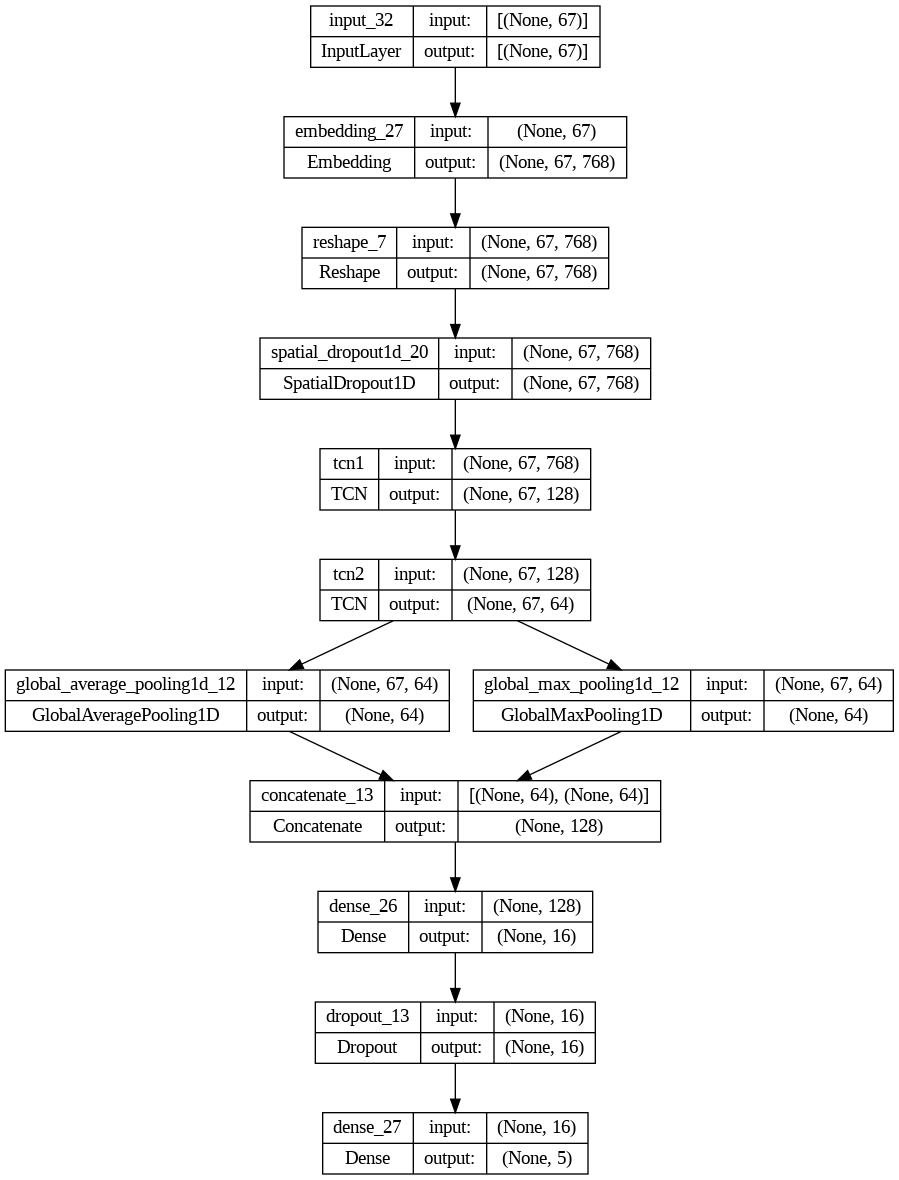

In [ ]:
plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    train_bert_embeddings_padded,
    y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(test_bert_embeddings_padded, y_test),
    verbose=1
)

Epoch 1/50


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py", line 118, in _fix_unknown_dimension
        raise ValueError(msg)

    ValueError: Exception encountered when calling layer 'reshape_1' (type Reshape).
    
    total size of new array must be unchanged, input_shape = [67, 768, 67], output_shape = [67, 67]
    
    Call arguments received by layer 'reshape_1' (type Reshape):
      • inputs=tf.Tensor(shape=(None, 67, 768, 67), dtype=float32)


In [ ]:
# Defining the model Ensemble CNN-GRU

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GRU, Dense, Dropout, concatenate, Flatten

# Define input layer
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Embedding layer
embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_layer)


In [ ]:
# Convolutional layers
conv1d_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding_layer)
conv1d_2 = Conv1D(filters=128, kernel_size=3, activation='relu')(conv1d_1)
maxpool_1 = MaxPooling1D(pool_size=2)(conv1d_2)
conv1d_3 = Conv1D(filters=128, kernel_size=3, activation='relu')(maxpool_1)
conv1d_4 = Conv1D(filters=256, kernel_size=3, activation='relu')(conv1d_3)
maxpool_2 = MaxPooling1D(pool_size=2)(conv1d_4)
conv1d_5 = Conv1D(filters=256, kernel_size=3, activation='relu')(maxpool_2)
conv1d_6 = Conv1D(filters=512, kernel_size=3, activation='relu')(conv1d_5)
maxpool_3 = MaxPooling1D(pool_size=2)(conv1d_6)

In [ ]:
# GRU layer
gru_layer = GRU(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)
gru_layer = GRU(units=256, dropout=0.2, recurrent_dropout=0.2)(gru_layer)


In [ ]:
# Concatenate features from CNN and GRU
flattened_cnn = Flatten()(maxpool_3)
concatenated = concatenate([flattened_cnn, gru_layer])

In [ ]:
# Dense layers
dense_1 = Dense(256, activation='relu')(concatenated)
dropout_1 = Dropout(0.5)(dense_1)
output_layer = Dense(NUM_CLASSES, activation='softmax')(dropout_1)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 350)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 350, 100)             1000000   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 348, 64)              19264     ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 346, 128)             24704     ['conv1d[0][0]']              
                                                                                              

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])


In [ ]:

# Train the model
history = model.fit(X_train, y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val))

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

def plot_metrics(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history)